In [1]:
# Uncomment these if the packages aren't recognized
#!pip install pygame
#!pip install numpy
#!pip install matplotlib
import pygame
import numpy as np
import matplotlib.pyplot as plt

pygame 2.0.0 (SDL 2.0.12, python 3.8.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [10]:
K1, K2 = 50, 50
beta = 0.5
N = 150

time_steps = 500
scale = 10

In [3]:
class Ant:
    def __init__(self, location, task, walking_style, information):
        self.l = location
        self.p = task
        self.w = walking_style
        self.f = information

    def draw(self):
        color = (255*self.f, 0, 255*(1-self.f))
        i, j = self.l
        pygame.draw.rect(win, color, (i*scale, j*scale, scale, scale))

In [4]:
class SFZ:
    '''
    Spatial Fidelity Zone (SFZ) on a grid of size K1 x K2.
    points: a set of all lattice points which are in the SFZ.
    '''
    def __init__(self, points, color = (100, 0, 100)):
        self.points = points
        self.color = color
    
    def dist(self, i, j):
        '''Returns the minimum L1 distance from (i,j) to the SFZ'''
        x = np.array([p[0] for p in self.points])
        y = np.array([p[1] for p in self.points])
        return np.amin(np.absolute(x-i) + np.absolute(y-j))

    def draw(self):
        for p in self.points:
            pygame.draw.rect(win, self.color, (p[0]*scale, p[1]*scale, scale + 1, scale + 1), 1)

In [5]:
class Colony:
    '''
    K1, K2 : dimensions of the grid
    N : number of ants within the colony
    P: number of distinct tasks within in the colony
    '''
    def __init__(self, K1, K2, N, sfzs = []):
        self.grid = np.zeros((K1, K2), dtype = int)
        self.ants = []
        self.sfzs = sfzs
        self.P = len(sfzs)
        while N > 0:
            i = np.random.randint(K1)
            j = np.random.randint(K2)
            if self.grid[i,j] == 0:
                p = np.random.randint(self.P)
                w = np.random.choice(['R','D'])
                f = (N == 1)
                ant = Ant((i,j), p, w, f)
                self.ants.append(ant)
                self.grid[i,j] = len(self.ants)
                N -= 1
        
        self.contacts = [0]
    
    def update(self):
        contacts = 0
        remaining_ants = list(range(len(self.ants)))
        while remaining_ants != []:
            n = remaining_ants.pop(np.random.randint(len(remaining_ants)))
            A = self.ants[n]
            i, j = A.l
            N = [(i+a, j+b) for a, b in [(1, 0), (-1, 0), (0, 1), (0, -1)] if min(i+a,j+b) > -1 and max(i+a,j+b) < min(K1, K2)]
            N = [self.ants[self.grid[a,b]-1] for a, b in N if self.grid[a,b] != 0]
            u1 = np.random.uniform(0, 1)
            if u1 > len(N) / 4:
                open_moves = [(i+a,j+b) for a, b in [(1, 0), (-1, 0), (0, 1), (0, -1)] if min(i+a,j+b) > -1 and max(i+a,j+b) < min(K1, K2)]
                open_moves = [(a,b) for a, b in open_moves if self.grid[a,b] == 0]
                if A.w == 'R' and len(open_moves) > 0:
                    new_i, new_j = open_moves[np.random.choice(len(open_moves))]
                    A.l = (new_i, new_j)
                    self.grid[i, j], self.grid[new_i, new_j] = 0, n+1
                elif A.w == 'D' and len(open_moves) > 0:
                    sfz = self.sfzs[A.p]
                    min_dist = min([sfz.dist(a, b) for a, b in open_moves])
                    open_moves = [(a,b) for a, b in open_moves if sfz.dist(a, b) == min_dist]
                    new_i, new_j = open_moves[np.random.choice(len(open_moves))]
                    A.l = (new_i, new_j)
                    self.grid[i, j], self.grid[new_i, new_j] = 0, n+1
            else:
                B = N[np.random.choice(len(N))]
                u2 = np.random.uniform(0, 1)
                if u2 < beta and A.f != B.f:
                    contacts += 1
                    A.f, B.f = 1, 1
                    A.l, B.l = B.l, A.l
                    self.grid[A.l[0],A.l[1]], self.grid[B.l[0],B.l[1]] = self.grid[B.l[0],B.l[1]], self.grid[A.l[0],A.l[1]]
        self.contacts.append(self.contacts[-1]+contacts)

    def draw(self):
        win.fill((255,255,255))
        for i in range(K1):
            for j in range(K2):
                pygame.draw.line(win, (230,230,230), (i*scale, j*scale), (K1*scale, j*scale))
                pygame.draw.line(win, (230,230,230), (i*scale, j*scale), (i*scale, K2*scale))
        for n in range(len(self.ants)):
            self.ants[n].draw()
        for n in range(len(self.sfzs)):
            self.sfzs[n].draw()
        pygame.display.update()

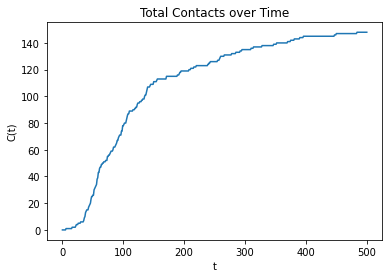

In [13]:
if __name__ == '__main__':
    run = True
    #win = pygame.display.set_mode((K1 * scale, K2 * scale))
    #pygame.display.set_caption('Ant Nest Simulator')

    sfzs = []
    sfzs.append(SFZ([(x,y) for x in range(15) for y in range(15)], (200, 0, 0)))
    #sfzs.append(SFZ([(x,y) for x in range(K1-15, K1) for y in range(15)], (200, 200, 0)))
    sfzs.append(SFZ([(x,y) for x in range(K1-15, K1) for y in range(K2-15, K2)], (0, 0, 200)))
    #sfzs.append(SFZ([(x,y) for x in range(15) for y in range(K2-15, K2)], (0, 200, 0)))

    colony = Colony(K1, K2, N, sfzs)
    
    t = 0
    clock = pygame.time.Clock()
    while run:
        colony.update()

        t += 1
        if t == time_steps:
            run = False

    plt.plot(colony.contacts)
    plt.title('Total Contacts over Time')
    plt.xlabel('t')
    plt.ylabel('C(t)')
    plt.show()